In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
pd.set_option('display.max_rows', None)

In [3]:
path_to_2d_objects_train = Path.cwd() / "resources" / "objects_2d_train.csv"
path_to_2d_objects_test = Path.cwd() / "resources" / "objects_2d_test.csv"
path_to_assigned_series = Path.cwd() / "resources" / "assigned_series_train.csv"
min_size_pixels = 10 # objects with size < min_size_pixels are removed
savefig = False

In [4]:
def get_train_df(path_to_train_objects, path_to_assigned):
    objects_train_df = pd.read_csv(path_to_train_objects)
    objects_train_df["series_uuid"] = objects_train_df.apply(lambda x: x["filename"].split(".nii.gz")[0], axis="columns")
    objects_train_df["lesion_label"] = objects_train_df.apply(lambda x: ",".join([x["lesion_type"], x["lesion_location"]]), axis="columns")
    assigned_df = pd.read_csv(path_to_assigned)
    objects_train_df = objects_train_df.merge(
        assigned_df,
        left_on="series_uuid",
        right_on="SeriesInstanceUID",
        how="left"
    )
    objects_train_df.rename(
        columns={"iteracion": "iteration"},
        inplace=True
    )
    return objects_train_df

In [5]:
def get_all_objects_df(path_to_train_objects, path_to_test_objects):
    train_df = pd.read_csv(path_to_train_objects)
    train_df["subset"] = "train"
    test_df = pd.read_csv(path_to_test_objects)
    test_df["subset"] = "test"
    df = pd.concat([train_df, test_df], ignore_index=True)
    df["lesion_label"] = df.apply(lambda x: ",".join([x["lesion_type"], x["lesion_location"]]), axis="columns")
    return df

In [6]:
objects_train_df = get_train_df(path_to_2d_objects_train, path_to_assigned_series)
objects_test_df = pd.read_csv(path_to_2d_objects_test)
all_objects_df = get_all_objects_df(path_to_2d_objects_train, path_to_2d_objects_test)

In [7]:
# Count and remove small objects
small_train = objects_train_df[objects_train_df["pixels_count"] < min_size_pixels].index.tolist()
small_test = objects_test_df[objects_test_df["pixels_count"] < min_size_pixels].index.tolist()
small_all = all_objects_df[all_objects_df["pixels_count"] < min_size_pixels].index.tolist()
print(f"objects with less than {min_size_pixels} pixels in training set: {len(small_train)}")
print(f"objects with less than {min_size_pixels} pixels in test set: {len(small_test)}")
print(f"total objects with less than {min_size_pixels} pixels: {len(small_all)}")
objects_train_df.drop(small_train, inplace=True)
objects_test_df.drop(small_test, inplace=True)
all_objects_df.drop(small_all, inplace=True)

objects with less than 10 pixels in training set: 252
objects with less than 10 pixels in test set: 78
total objects with less than 10 pixels: 330


In [8]:
# Evolution of total annotated 2d objects (train set)
grouped = objects_train_df.groupby(["iteration"]).size().reset_index(name="annotated_2d_objects_train")
grouped["accumulated"] = grouped["annotated_2d_objects_train"].cumsum()
display(grouped)

,iteration,annotated_2d_objects_train,accumulated
0,1,4140,4140
1,2,852,4992
2,3,2421,7413


In [9]:
# Evolution of annotated 2b objects grouped by lesion label
grouped = objects_train_df.groupby(["lesion_label", "iteration"]).size().reset_index(name="annotated_2d_objects_train")
all_groups = grouped['lesion_label'].unique()
all_iterations = [1, 2, 3]  # All possible iteration values
multi_index = pd.MultiIndex.from_product([all_groups, all_iterations], names=['lesion_label', 'iteration'])
# Reindex the grouped DataFrame to include all combinations
completed = grouped.set_index(['lesion_label', 'iteration']).reindex(multi_index, fill_value=0).reset_index()

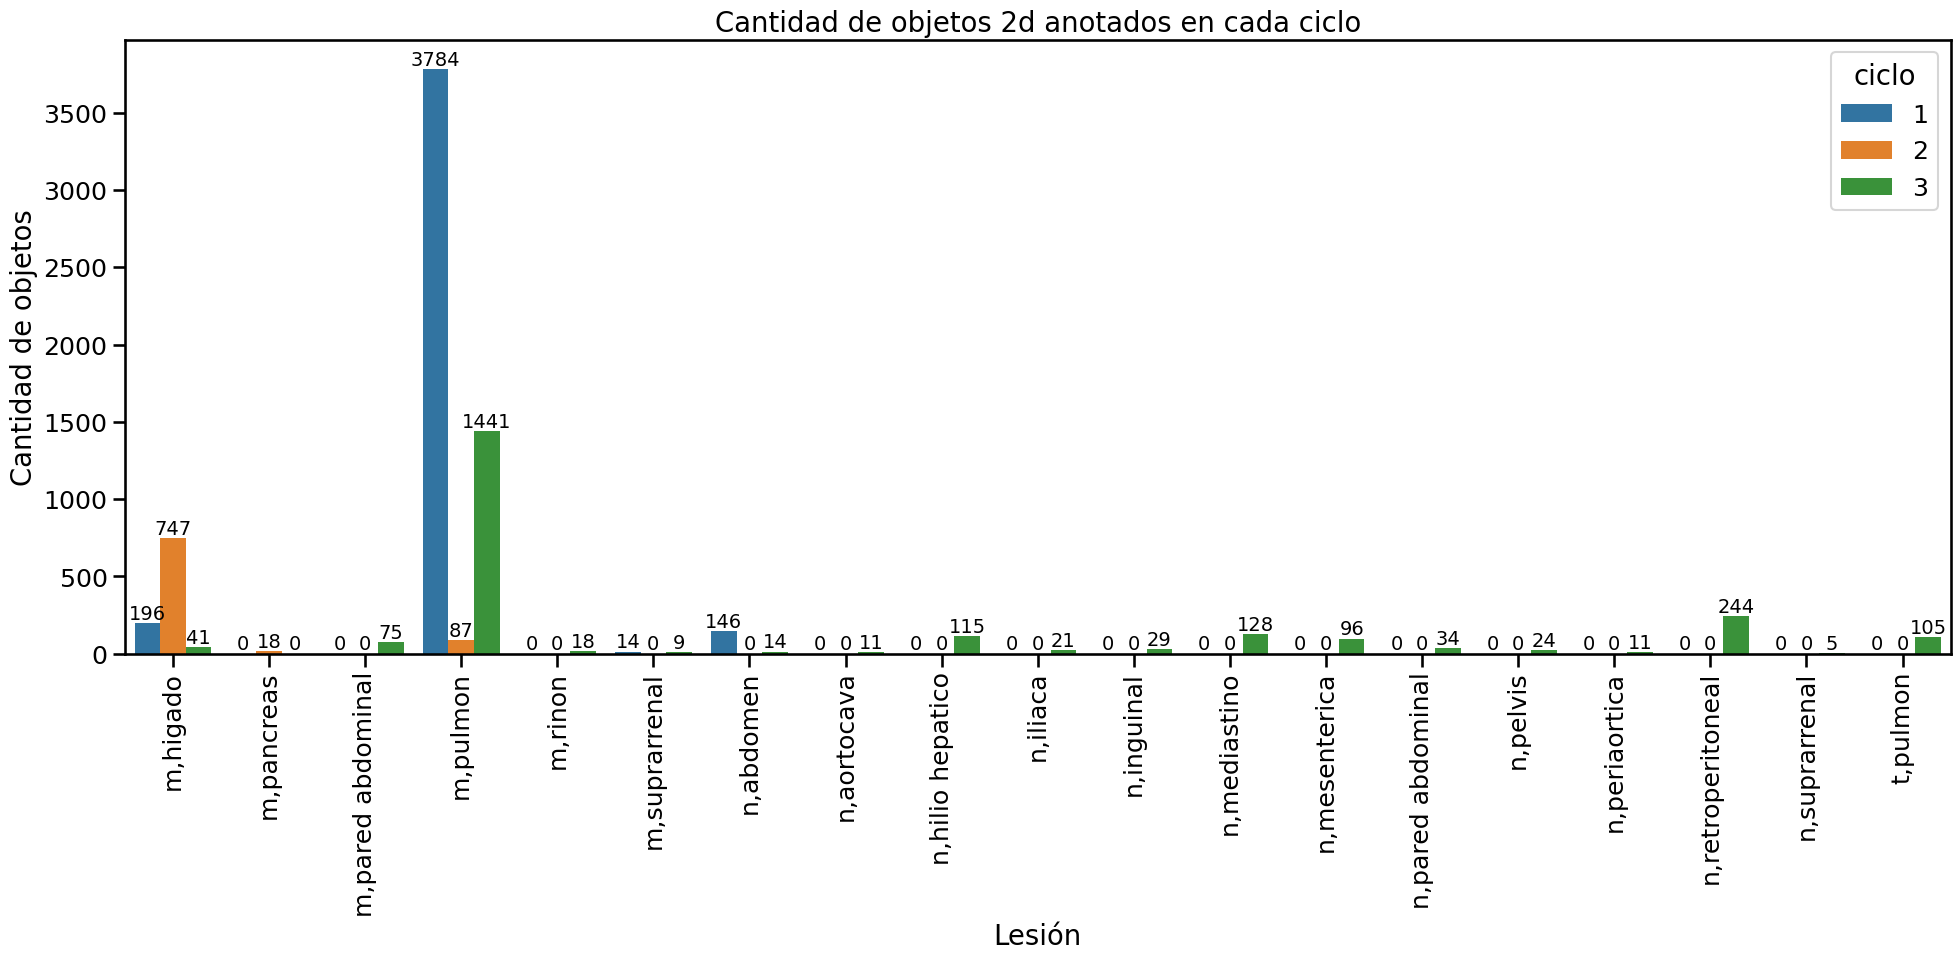

In [10]:
plt.figure(figsize=(20,10))
sns.set_context("talk", font_scale=1.1)
ax = sns.barplot(
    data=completed,
    x="lesion_label",
    y="annotated_2d_objects_train",
    hue="iteration"
)
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f', fontsize=14)
plt.title("Cantidad de objetos 2d anotados en cada ciclo")
plt.xlabel("Lesión")
plt.ylabel("Cantidad de objetos")
plt.xticks(rotation=90)
plt.legend(title="ciclo")
plt.tight_layout()
if savefig:
    plt.savefig("resources/results/annotated_2d_objects_grouped_and_evolution.png", transparent=True)
plt.show()

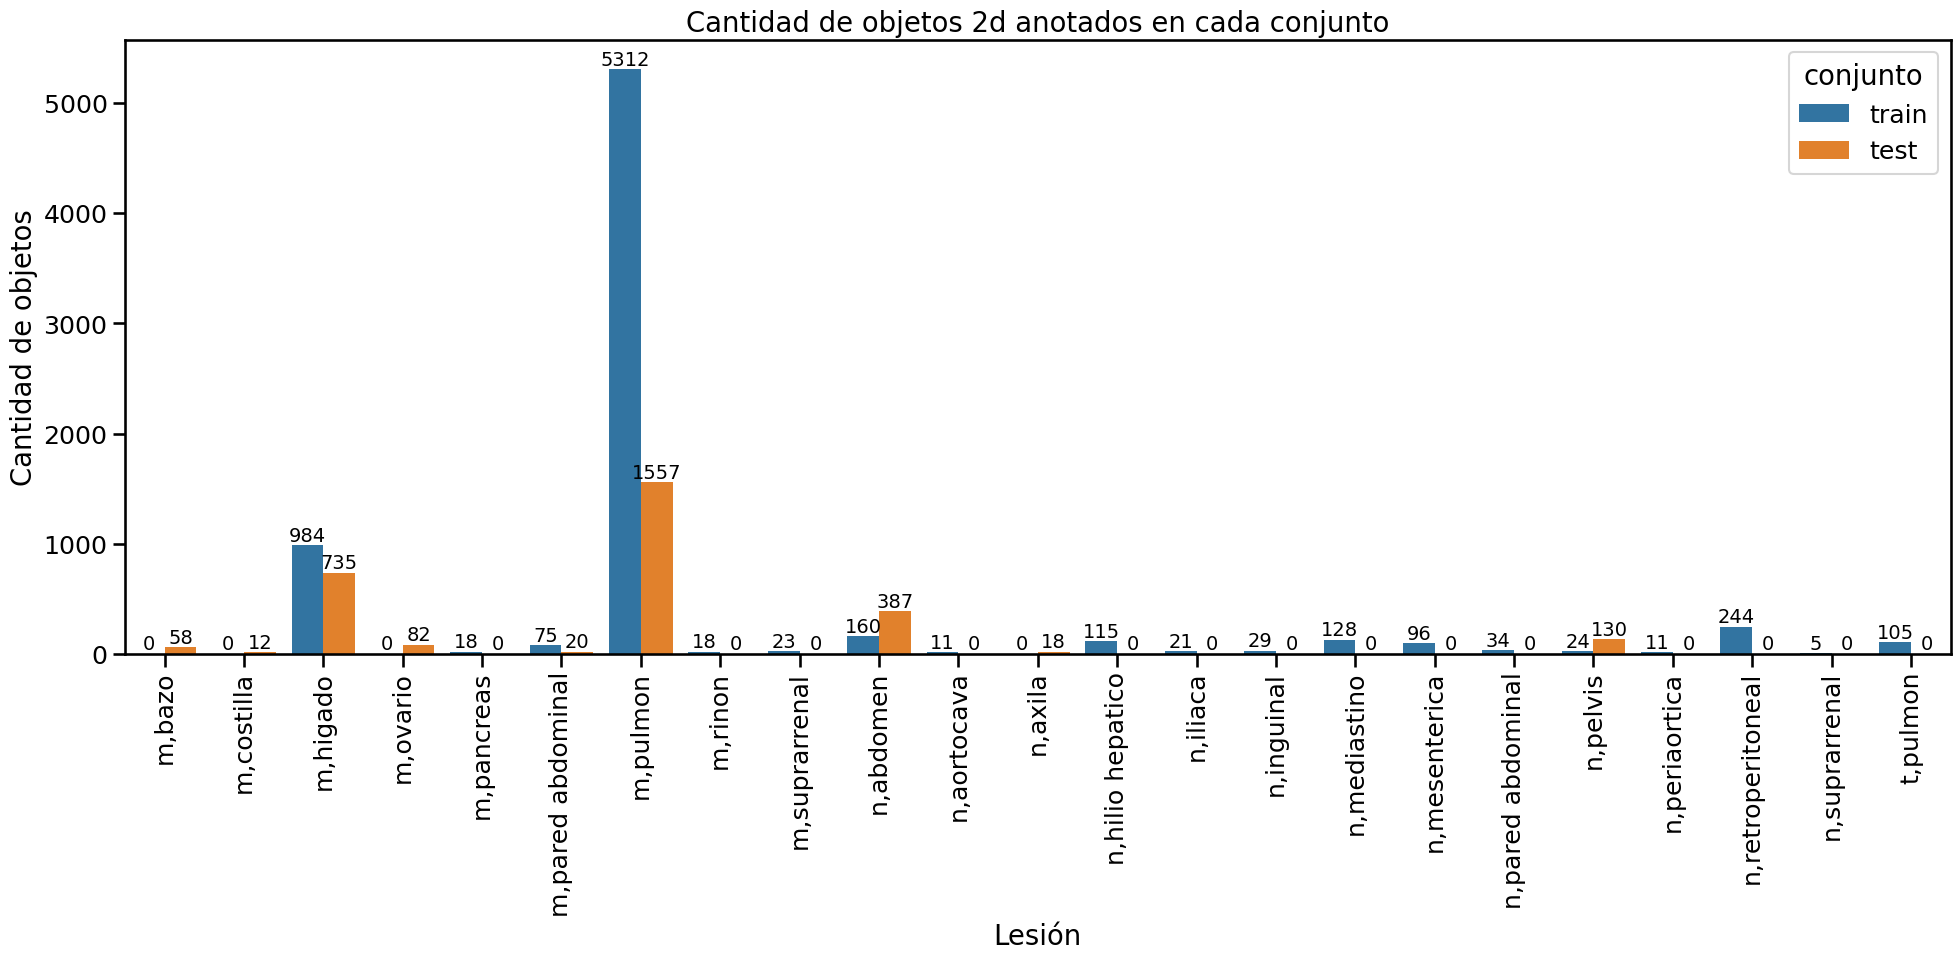

In [11]:
grouped = all_objects_df.groupby(['lesion_label', 'subset']).size().reset_index(name="annotated_2d_objects")
# Complete with zeros
all_groups = grouped['lesion_label'].unique()
all_subsets = ["train", "test"]
multi_index = pd.MultiIndex.from_product([all_groups, all_subsets], names=['lesion_label', 'subset'])
grouped = grouped.set_index(['lesion_label', 'subset']).reindex(multi_index, fill_value=0).reset_index()
# Barplot
plt.figure(figsize=(20,10))
sns.set_context("talk", font_scale=1.1)
ax = sns.barplot(
    data=grouped,
    x="lesion_label",
    y="annotated_2d_objects",
    hue="subset",
    hue_order=["train", "test"]
)
for bars in ax.containers:
    ax.bar_label(bars, fmt='%.0f', fontsize=14)
plt.title("Cantidad de objetos 2d anotados en cada conjunto")
plt.xlabel("Lesión")
plt.ylabel("Cantidad de objetos")
plt.xticks(rotation=90)
plt.legend(title="conjunto")
plt.tight_layout()
if savefig:
    plt.savefig("resources/results/annotated_2d_objects_grouped_and_subsets.png", transparent=True)
plt.show()